In [ ]:
# =========================================
# 1. Mount Drive & Import Library
# =========================================
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import math
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from graphviz import Digraph
import joblib

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# =========================================
# 2. Load Dataset
# =========================================
data_path = "/content/drive/MyDrive/Artikel_Publikasi_Ilmiah/Dataset_Responden/Dataset_Analisis.csv"
output_path = "/content/drive/MyDrive/Artikel_Publikasi_Ilmiah/Hasil_Analisis"
model_path = "/content/drive/MyDrive/Artikel_Publikasi_Ilmiah/Model_Evaluasi"

data = pd.read_csv(data_path, sep=';')
data.head()

,Responden,TN1,TN2,TN3,RL1,RL2,RL3,RS1,RS2,RS3,AS1,AS2,AS3,EP1,EP2,EP3,Kepuasan
0,1,Setuju,Setuju,Sangat Setuju,Setuju,Setuju,Sangat Setuju,Cukup,Cukup,Tidak Setuju,Tidak Setuju,Cukup,Tidak Setuju,Cukup,Tidak Setuju,Tidak Setuju,Tidak Puas
1,2,Sangat Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Puas
2,3,Sangat Setuju,Setuju,Setuju,Sangat Setuju,Setuju,Setuju,Cukup,Setuju,Setuju,Setuju,Setuju,Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Puas
3,4,Cukup,Cukup,Cukup,Cukup,Cukup,Cukup,Cukup,Cukup,Cukup,Cukup,Cukup,Cukup,Cukup,Cukup,Cukup,Tidak Puas
4,5,Sangat Setuju,Sangat Setuju,Sangat Setuju,Setuju,Sangat Setuju,Sangat Setuju,Setuju,Sangat Setuju,Sangat Setuju,Setuju,Sangat Setuju,Sangat Setuju,Sangat Setuju,Setuju,Sangat Setuju,Puas


In [ ]:
# =========================================
# 3. Cek Missing Value & Distribusi Target
# =========================================
print("\nJumlah Data:\n", len(data))
print("\nCek Missing Value:\n", data.isnull().sum())
print("\nDistribusi Target:\n", data['Kepuasan'].value_counts())


Jumlah Data:
 125

Cek Missing Value:
 Responden    0
TN1          0
TN2          0
TN3          0
RL1          0
RL2          0
RL3          0
RS1          0
RS2          0
RS3          0
AS1          0
AS2          0
AS3          0
EP1          0
EP2          0
EP3          0
Kepuasan     0
dtype: int64

Distribusi Target:
 Kepuasan
Puas          67
Tidak Puas    58
Name: count, dtype: int64


In [ ]:
# =========================================
# 4. Perhitungan Entropy, IG, Split Info, Gain Ratio
# =========================================
def calculate_entropy(y):
    counts = Counter(y)
    probabilities = [count / len(y) for count in counts.values()]
    return -sum(p * math.log2(p) for p in probabilities if p > 0)

def calculate_metrics(data, feature, target):
    total_entropy = calculate_entropy(data[target])
    weighted_entropy = 0
    split_info = 0

    for value in data[feature].unique():
        subset = data[data[feature] == value]
        weight = len(subset) / len(data)
        ent = calculate_entropy(subset[target])
        weighted_entropy += weight * ent
        if weight > 0:
            split_info -= weight * math.log2(weight)

    information_gain = total_entropy - weighted_entropy
    gain_ratio = information_gain / split_info if split_info > 0 else 0

    return {
        'feature': feature,
        'information_gain': information_gain,
        'split_info': split_info,
        'gain_ratio': gain_ratio
    }


Gain Ratio Tiap Fitur:
   feature  information_gain  split_info  gain_ratio
11     AS3          0.549559    1.757335    0.312723
12     EP1          0.559451    1.807776    0.309469
10     AS2          0.529582    1.775281    0.298309
5      RL3          0.517309    1.740168    0.297275
13     EP2          0.541201    1.865327    0.290137
0      TN1          0.542554    1.897473    0.285935
1      TN2          0.506866    1.773523    0.285796
14     EP3          0.488599    1.827315    0.267386
3      RL1          0.453764    1.844264    0.246041
9      AS1          0.443383    1.827030    0.242680
4      RL2          0.432597    1.900760    0.227591
2      TN3          0.358700    1.704207    0.210479
8      RS3          0.383031    1.832239    0.209051
6      RS1          0.322027    1.765887    0.182360
7      RS2          0.170634    1.715953    0.099440


<ipython-input-5-f76782965b22>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='gain_ratio', y='feature', data=gain_df, palette='mako')


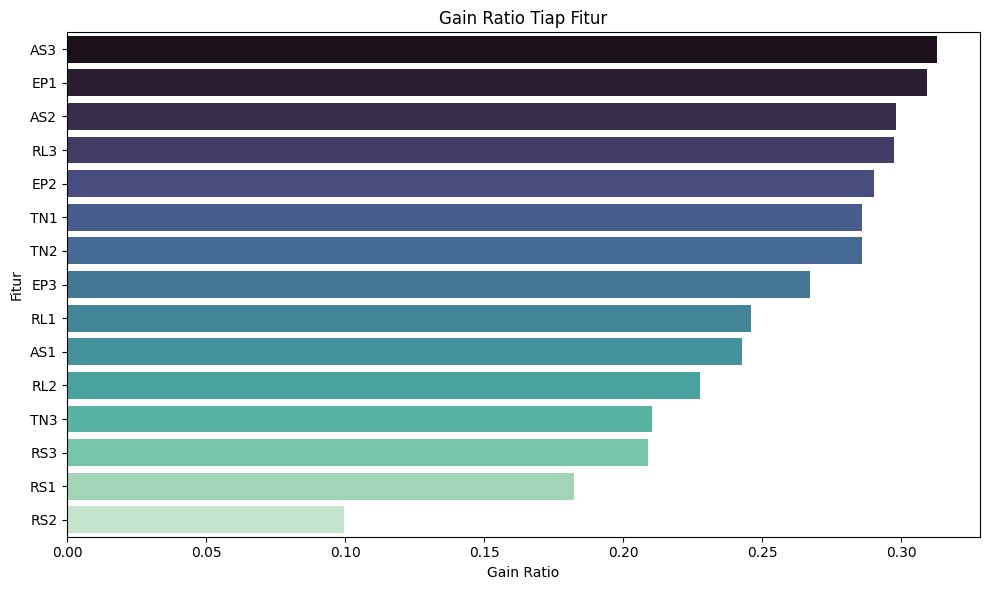

In [ ]:

# =========================================
# 5. Menghitung Gain Ratio Semua Fitur
# =========================================
target_column = 'Kepuasan'
features = [col for col in data.columns if col not in ['Responden', target_column]]

gain_metrics = [calculate_metrics(data, f, target_column) for f in features]
gain_df = pd.DataFrame(gain_metrics).sort_values(by='gain_ratio', ascending=False)

print("\nGain Ratio Tiap Fitur:")
print(gain_df)

# Simpan tabel ke CSV
gain_df.to_csv(f"{output_path}/gain_ratio_tiap_fitur.csv", index=False)

# Visualisasi Gain Ratio
plt.figure(figsize=(10,6))
sns.barplot(x='gain_ratio', y='feature', data=gain_df, palette='mako')
plt.title('Gain Ratio Tiap Fitur')
plt.xlabel('Gain Ratio')
plt.ylabel('Fitur')
plt.tight_layout()
plt.savefig(f"{output_path}/gain_ratio_visual.png")
plt.show()

In [ ]:
# =========================================
# 6. Split Data
# =========================================
X = data[features]
y = data[target_column]
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)


In [ ]:
# =========================================
# 7. Model Decision Tree (fit untuk evaluasi saja)
# =========================================
categorical_features = X.columns.tolist()
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)]
)

le = LabelEncoder()
y_encoded = le.fit_transform(y)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(criterion='entropy', random_state=42))
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['TN1', 'TN2', 'TN3', 'RL1',
                                                   'RL2', 'RL3', 'RS1', 'RS2',
                                                   'RS3', 'AS1', 'AS2', 'AS3',
                                                   'EP1', 'EP2', 'EP3'])])),
                ('classifier',
                 DecisionTreeClassifier(criterion='entropy', random_state=42))])

In [ ]:
# Simpan model ke Drive
joblib.dump(pipeline, f"{model_path}/decision_tree_pipeline.joblib")

['/content/drive/MyDrive/Artikel_Publikasi_Ilmiah/Model_Evaluasi/decision_tree_pipeline.joblib']


Akurasi: 0.84

Classification Report:
               precision    recall  f1-score   support

        Puas       0.80      0.92      0.86        13
  Tidak Puas       0.90      0.75      0.82        12

    accuracy                           0.84        25
   macro avg       0.85      0.84      0.84        25
weighted avg       0.85      0.84      0.84        25



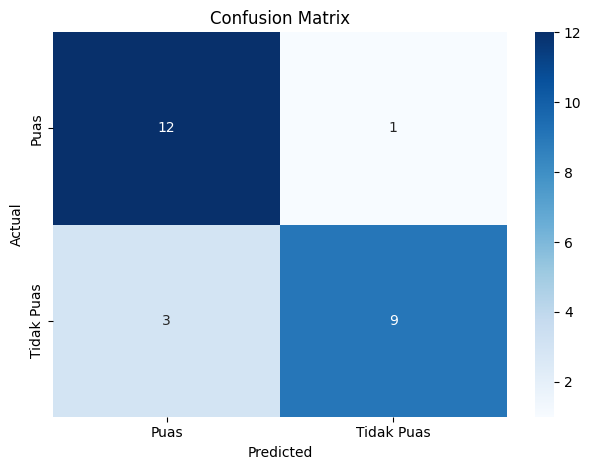

In [ ]:
# =========================================
# 8. Evaluasi Model
# =========================================
y_pred = pipeline.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("\nAkurasi:", accuracy)
print("\nClassification Report:\n", report)

# Simpan evaluasi ke file
with open(f"{output_path}/evaluasi_model.txt", "w") as f:
    f.write(f"Akurasi: {accuracy:.4f}\n\n")
    f.write("Classification Report:\n")
    f.write(report)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(f"{output_path}/confusion_matrix.png")
plt.show()

In [ ]:
# =========================================
# 9. Cross-Validation
# =========================================
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X, y, cv=cv, scoring='f1_macro')
print("\nCross-Validation F1 Macro Scores:", cv_scores)
print("Rata-rata F1 Macro:", np.mean(cv_scores))

with open(f"{output_path}/cross_validation_result.txt", "w") as f:
    f.write("Cross-Validation F1 Macro Scores:\n")
    f.write(str(cv_scores))
    f.write("\nRata-rata F1 Macro: " + str(np.mean(cv_scores)))


Cross-Validation F1 Macro Scores: [1.         0.96       0.96       0.87684729 0.79474548]
Rata-rata F1 Macro: 0.91831855500821


In [ ]:
# =========================================
# 10. Pohon Keputusan Manual (C4.5)
# =========================================
class Node:
    def __init__(self, attribute=None, value=None, children=None):
        self.attribute = attribute
        self.value = value
        self.children = children or {}

def build_tree(data, features, target, depth=0, max_depth=3):
    if len(data[target].unique()) == 1:
        return Node(value=data[target].iloc[0])
    if not features or depth >= max_depth:
        majority = data[target].mode()[0]
        return Node(value=majority)

    gain_dict = {f: calculate_metrics(data, f, target)['gain_ratio'] for f in features}
    best_feature = max(gain_dict, key=gain_dict.get)

    tree = Node(attribute=best_feature)
    for val in data[best_feature].unique():
        subset = data[data[best_feature] == val]
        if subset.empty:
            tree.children[val] = Node(value=data[target].mode()[0])
        else:
            new_features = [f for f in features if f != best_feature]
            tree.children[val] = build_tree(subset, new_features, target, depth+1, max_depth)

    return tree

def print_tree(node, indent=""):
    if node.value is not None:
        print(f"{indent}Prediksi: {node.value}")
    else:
        print(f"{indent}[{node.attribute}]")
        for val, child in node.children.items():
            print(f"{indent} └── {val}")
            print_tree(child, indent + "    ")

print("\nPohon Keputusan Manual:")
manual_tree = build_tree(data, features, target_column, max_depth=3)
print_tree(manual_tree)



Pohon Keputusan Manual:
[AS3]
 └── Tidak Setuju
    Prediksi: Tidak Puas
 └── Sangat Setuju
    [RL3]
     └── Sangat Setuju
        Prediksi: Puas
     └── Setuju
        Prediksi: Puas
     └── Tidak Setuju
        Prediksi: Tidak Puas
 └── Setuju
    [EP1]
     └── Sangat Setuju
        Prediksi: Puas
     └── Setuju
        [RL2]
         └── Setuju
            Prediksi: Puas
         └── Cukup
            Prediksi: Tidak Puas
         └── Sangat Setuju
            Prediksi: Puas
     └── Cukup
        Prediksi: Tidak Puas
     └── Tidak Setuju
        Prediksi: Tidak Puas
 └── Cukup
    Prediksi: Tidak Puas
 └── Sangat Tidak Setuju
    Prediksi: Tidak Puas


In [ ]:
# =========================================
# 11. Visualisasi Pohon Manual
# =========================================
def visualize_tree_graphviz(node, graph=None, node_id=0):
    if graph is None:
        graph = Digraph()

    current_id = str(node_id)

    if node.value is not None:
        graph.node(current_id, label=f'Prediksi: {node.value}', shape='box', style='filled', fillcolor='lightblue')
    else:
        graph.node(current_id, label=node.attribute, shape='ellipse', style='filled', fillcolor='lightyellow')
        for i, (val, child) in enumerate(node.children.items()):
            child_id = str(node_id * 10 + i + 1)
            graph.edge(current_id, child_id, label=str(val))
            visualize_tree_graphviz(child, graph, int(child_id))

    return graph

graph = visualize_tree_graphviz(manual_tree)
graph.render(f"{output_path}/pohon_keputusan_manual", format='png', cleanup=True)

'/content/drive/MyDrive/Artikel_Publikasi_Ilmiah/Hasil_Analisis/pohon_keputusan_manual.png'

In [ ]:
# =========================================
# 12. Analisis Tambahan: Simpul & Kedalaman
# =========================================
def count_nodes_and_depth(node, depth=0):
    if node.value is not None:
        return 1, depth
    total_nodes = 1
    max_depth = depth
    for child in node.children.values():
        child_nodes, child_depth = count_nodes_and_depth(child, depth + 1)
        total_nodes += child_nodes
        max_depth = max(max_depth, child_depth)
    return total_nodes, max_depth

total_nodes, max_tree_depth = count_nodes_and_depth(manual_tree)
print(f"\nJumlah Simpul Pohon Manual: {total_nodes}")
print(f"Kedalaman Maksimum Pohon Manual: {max_tree_depth}")

with open(f"{output_path}/info_pohon_manual.txt", "w") as f:
    f.write(f"Jumlah Simpul Pohon Manual: {total_nodes}\n")
    f.write(f"Kedalaman Maksimum Pohon Manual: {max_tree_depth}")


Jumlah Simpul Pohon Manual: 16
Kedalaman Maksimum Pohon Manual: 3
